# STOXX600

## Lendo arquivo de dados Ibovespa

In [1]:
import pandas as pd

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

df = ler_csv('dados/STOXX_600.csv')

In [2]:
df

,Data,Último
0,29.12.2023,479.02
1,28.12.2023,478.08
2,27.12.2023,478.62
3,22.12.2023,477.60
4,21.12.2023,476.94
...,...,...
2750,19.04.2013,285.21
2751,18.04.2013,283.73
2752,17.04.2013,283.73
2753,16.04.2013,288.16


## Pré - tratamento dos dados

In [3]:
def df_tratamento_dados(df):
    df = df.rename(columns={'Data':'data','Último': 'value'})
    df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')
    
    #df['value'] = df['value'].astype(str)
    #df['value'] = df['value'].str.replace('.', '',regex=False)  # Remove o ponto dos milhares
    #df['value'] = df['value'].str.replace(',', '.',regex=False)  # Substitui a vírgula por ponto
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['value'] = df['value'].interpolate(method='linear')
    df.set_index('data', inplace=True)
    df.sort_index(ascending=True, inplace=True)
    df = df.asfreq('D')
    return df

In [4]:
df_arima = df_tratamento_dados(df)

In [5]:
df_arima.tail(20)

,value
data,
2023-12-10,473.220
2023-12-11,473.700
2023-12-12,472.720
2023-12-13,472.460
2023-12-14,476.570
2023-12-15,476.610
2023-12-16,476.180
2023-12-17,475.750
2023-12-18,475.320


# Separando os dados de treino e de teste

In [6]:
def split(df_arima, perc):
    train = df_arima[:int(len(df_arima)*perc)]
    test = df_arima[len(train):]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 0.8)

3128
783


In [145]:
def split(df_arima, days):
    train = df_arima[:-days]
    test = df_arima[-days:]
    print(len(train))
    print(len(test))
    return train, test

arima_train, arima_test = split(df_arima, 380)

3531
380


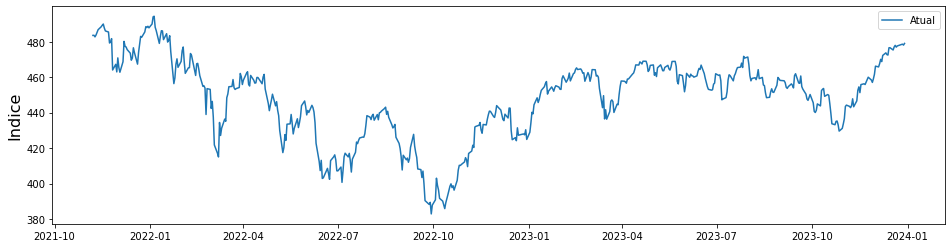

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(arima_test, label="Atual")
plt.title('', fontsize=20)
plt.ylabel('Indice', fontsize=16)
plt.legend()

In [7]:
arima_test

,value
data,
2023-09-21,454.670
2023-09-22,453.260
2023-09-23,452.320
2023-09-24,451.380
2023-09-25,450.440
...,...
2023-12-25,478.212
2023-12-26,478.416
2023-12-27,478.620


## Decompondo a série

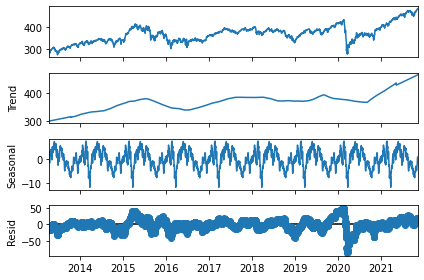

In [281]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
result = seasonal_decompose(arima_train, model='additive',period=365,extrapolate_trend='freq')
result.plot()
plt.show()

## Verificando estacionariedade da série e da componente sasonal

In [282]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(df):
    dftest = adfuller(df)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [283]:
# Componente sasonal
seasonal = result.seasonal
check_stationarity(seasonal)

The series is stationary


In [284]:
# série temporal
check_stationarity(arima_train['value'])

The series is NOT stationary


## Plotando os gráficos de ACF e PCF da série

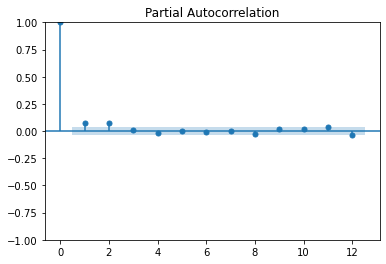

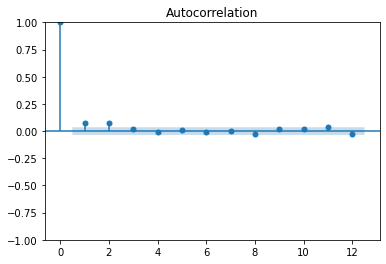

In [285]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(arima_train.diff().dropna(), lags =12)
plt.show()
plot_acf(arima_train.diff().dropna(), lags =12)
plt.show()

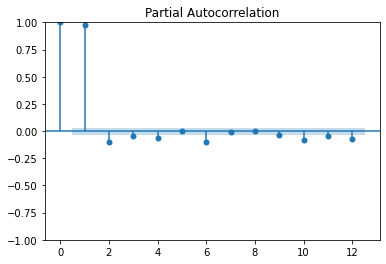

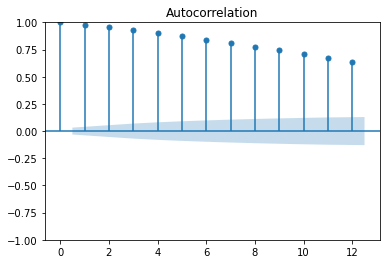

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(seasonal, lags =12)
plt.show()
plot_acf(seasonal, lags =12)
plt.show()

#### Analisando os gráficos pode ser visto que uma possível configuração pode ser pdq = 1,1,1 e PDQ = 0,0,1

In [8]:
ACF_PACF_config = [(2,1,2),(4,0,0, 12),'n']

# Parâmetros com auto arima

In [9]:
from pmdarima import auto_arima

# Suponha que 'data' seja a sua série temporal
auto_arima_config = auto_arima(arima_train, seasonal=True, m=12)  # m é o período da sazonalidade

In [10]:
# Obter os parâmetros 'order' e 'seasonal_order'
order = auto_arima_config.order
seasonal_order = auto_arima_config.seasonal_order
auto_arima_config = [order,seasonal_order,'n']
auto_arima_config

[(0, 1, 2), (0, 0, 1, 12), 'n']

##### O Auto Arima retornou como parãmetros pdq = 0,1,0 e PDQ = 0,0,0

# Parâmetros com grid search

## Carregando funções

In [301]:
import itertools
def sarima_parameter_search(inicio, search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p =d= q = range(inicio, search_range)
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(inicio = 0,search_range = 2)

In [302]:
len(order_combos)*len(seasonal_order_combos)

256

In [11]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
def seasonal_arima_model(time_series=None, order=None, seasonal_order=None, trend=None, steps=None, modo=None):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        if modo == "SARIMA":
            model = SARIMAX(time_series, 
                                       order=order, 
                                       seasonal_order=seasonal_order, 
                                       trend = trend,
                                       enforce_stationarity=False, 
                                       enforce_invertibility=False)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            # Calcule o MAE, MAPE e RMSE
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            mae = mean_absolute_error(arima_test, prediction)
            mape = mean_absolute_percentage_error(arima_test, prediction)
            return rmse,mae,mape, model_fit, prediction
        elif modo == "ARIMA":         
            model = ARIMA(time_series, order=order)
            model_fit = model.fit()
            prediction = model_fit.forecast(steps=steps)
            rmse = np.sqrt(mean_squared_error(arima_test, prediction))
            
            return rmse, model_fit, prediction
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

def grid_search(order_combos,seasonal_order_combos, df, steps, modo):
    lowest_rmse = 100000000000
    lowest_mae = 100000000000
    lowest_mape = 100000000000
    
    if modo == "ARIMA":
        for order_combo in order_combos:
            #Generate the ARIMA model
            rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                        order = order_combo, 
                                                        steps=steps,
                                                        modo=modo)
            print("order-- ", order_combo, ", lowest_rmse--",rmse)
            if (rmse < lowest_rmse):
                lowest_rmse = rmse
                best_model = model_fit
                best_order = order_combo
        melhor_conf = best_order
        return lowest_rmse,best_model,melhor_conf
                
    elif modo == "SARIMA":
        #Generate  model for each of hyperparameter combination in a loop
        for order_combo in order_combos:
            for seasonal_order_combo in seasonal_order_combos:
                #Convert the combination to list format
                seasonal_order_combo = list(seasonal_order_combo)
                #Generate the SARIMA model
                rmse,mae,mape,model_fit, prediction  = seasonal_arima_model(time_series = df, 
                                                            order = order_combo, 
                                                            seasonal_order = seasonal_order_combo[0:4],
                                                            trend = seasonal_order_combo[-1],
                                                            steps=steps,
                                                            modo=modo)
                print("order-- ", order_combo, ", seasonal order-- ", seasonal_order_combo, ", rmse--",rmse,", mae--",mae,", mape--",mape)
                if (rmse < lowest_rmse) or (mae < lowest_mae) or (mape < lowest_mape):
                    lowest_rmse = rmse
                    lowest_mae = mae
                    lowest_mape = mape
                    best_model = model_fit
                    best_order = order_combo
                    best_seasonal_order = seasonal_order_combo

                #print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order, ", lowest_rmse--",lowest_rmse)
        melhor_conf = [best_order,tuple(best_seasonal_order[0:4]),best_seasonal_order[-1]]
        return lowest_rmse,lowest_mae,lowest_mape,best_model,melhor_conf

In [304]:
rmse,model, grid_search_melhor_conf, = grid_search(order_combos,seasonal_order_combos, arima_train, len(arima_test), "SARIMA")
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 448.5525346947405
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 81.87050229114885
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 206.88717117953243
order--  (0, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 30.640818362468707
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 445.6213490099128
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 80.68913919089638
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , lowest_rmse-- 205.9598706964026
order--  (0, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , lowest_rmse-- 29.69247802004934
order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , lowest_rmse-- 38.265821226836145
order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , lowest_rmse-- 60.6905436843337
order--  (0, 0, 0) , seasonal order--  [0, 1, 0, 12, 't'] , lowest_rmse-- 83

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 86.23195130736524


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 32.10455488603542
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 38.3029708788484
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 59.48290050810201
order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 83.30645120193839


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 74.38497927926028
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 38.03938684641011
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 58.383951365218714
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 82.71222700537275
order--  (0, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 74.38397384148124
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 448.2897491093524
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 81.74510755577704
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 206.84242012484472
order--  (0, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 30.646050550061926
order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 445.3672688573726
order--  (0, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 45.31218262251132
order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 89.52712957710376


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 36.91389543709639
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 61.34023274441314


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 40.80543516137103


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 53.99583419615348
order--  (0, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 32.4723233710912
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 37.78515709037208
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 59.0466304261139
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 82.00004660217407
order--  (0, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 75.0712339266052
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 35.7398055841899
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 55.21835393287968
order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 78.18114383570091


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 69.3060541994393
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 42.091710727010756
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 65.36960303600263
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 89.0060656906671
order--  (0, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 81.5374169363819
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 41.8678784530734
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 64.05257703945685
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , lowest_rmse-- 88.63154520516812
order--  (0, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , lowest_rmse-- 81.12553352515
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , lowest_rmse-- 456.9680595391783
order--  (0, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , lowest_rmse-- 466.16036

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , lowest_rmse-- 353.6675450277946
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , lowest_rmse-- 41.88170429598887
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 64.24395224762374
order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 87.67985887856746


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 80.38491870715261
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 41.85851494911865
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 64.00087506985535
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 88.6046135603167
order--  (0, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 81.1213842200889
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 464.48324200728473
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 480.75521352760876
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 546.7833587305307
order--  (0, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 609.41803133675
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 65.05227707798618
order--  (0, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 81.67

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 86.14456299142766


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 76.94619381567624
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 41.81957399604209
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 64.09980690680783


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 't'] , lowest_rmse-- 85.92217327900593
order--  (0, 1, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , lowest_rmse-- 76.71915233534514
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , lowest_rmse-- 456.9042684975665
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , lowest_rmse-- 448.7048578230169
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , lowest_rmse-- 576.3122486404744
order--  (0, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , lowest_rmse-- 728.3247494259057
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , lowest_rmse-- 65.44964374077207
order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , lowest_rmse-- 80.84032975332724


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , lowest_rmse-- 253.81749780236186


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , lowest_rmse-- 423.3902923705271
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , lowest_rmse-- 41.83947973535801
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 64.11105319915917
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 84.88461726355273
order--  (0, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 75.9012695395056
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 41.792827169836954
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 63.7888079565401


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 86.00567016670557
order--  (0, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 76.78512949878844
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 462.3395533815744
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 474.68171526857844
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 543.3899025368795
order--  (0, 1, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 645.3937026705922
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 64.28080135693085
order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 82.68006981357489


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 281.44511998500997


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (0, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 445.99965786487627
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 69.53863614090082
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 28.334265065961898
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 91.03843321031557
order--  (1, 0, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 22.671737339406256
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 67.65153160507997
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 28.62842562266471
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 't'] , lowest_rmse-- 81.06999538869466
order--  (1, 0, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , lowest_rmse-- 21.65211542951333
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , lowest_rmse-- 49.43855073301745
order--  (1, 0, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , lowest_rmse-- 

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 't'] , lowest_rmse-- 144.4655288025194
order--  (1, 0, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , lowest_rmse-- 189.23777623605383
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , lowest_rmse-- 68.5716844509924
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 28.023591338240283
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 80.24207513585897
order--  (1, 0, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 21.458504583553687
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 66.5614675218508
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 35.42189422682043


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 76.16725143919145
order--  (1, 0, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 23.09639296917676
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 55.73514763655679
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 78.07109255305888
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 98.83507923769038
order--  (1, 0, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 92.22458043717272
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 28.287293908095698
order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 22.712655836499806


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 126.03022090856658


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 159.69972052956626
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 68.96818472370371
order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 30.783680439750363


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 89.51573673066413


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 21.13027129841177
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 67.3342281393151
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 31.218132069930473
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 't'] , lowest_rmse-- 80.8627085540216
order--  (1, 0, 1) , seasonal order--  [0, 0, 1, 12, 'ct'] , lowest_rmse-- 20.77570995645989
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'n'] , lowest_rmse-- 48.16116159455334
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'c'] , lowest_rmse-- 70.92742511476133
order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 't'] , lowest_rmse-- 94.35761534608454


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , lowest_rmse-- 93.02181406569183
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , lowest_rmse-- 31.002469103715143
order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , lowest_rmse-- 20.9619841229863


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 't'] , lowest_rmse-- 132.2639264842702


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , lowest_rmse-- 1348.0436032958748
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , lowest_rmse-- 67.17893071781758
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 30.532540718640952


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 88.37940072121056
order--  (1, 0, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 20.794670644797762
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 66.78871064371207
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 45.51642240521841


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 82.92739994267062
order--  (1, 0, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 25.538588037753883
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 53.08681841719104
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 75.71140658528151


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 103.54790733885524
order--  (1, 0, 1) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 92.87039804802451
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 30.100976045055546
order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 20.951360061229405


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 90.11397065757811


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 0, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 88.6407540253765
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 42.095470238815196
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 65.37963235706295
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 89.00109323644963
order--  (1, 1, 0) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 80.6847109260318
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse-- 41.81341608993891
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'c'] , lowest_rmse-- 63.96299827018399
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 't'] , lowest_rmse-- 88.59670983160999
order--  (1, 1, 0) , seasonal order--  [0, 0, 1, 12, 'ct'] , lowest_rmse-- 80.26997898498979
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'n'] , lowest_rmse-- 456.8948189218934
order--  (1, 1, 0) , seasonal order--  [0, 1, 0, 12, 'c'] , lowest_rmse-- 465.

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 't'] , lowest_rmse-- 248.03958867999305


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [0, 1, 1, 12, 'ct'] , lowest_rmse-- 386.4839540127664
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'n'] , lowest_rmse-- 41.83409152384263
order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 64.03921444918343


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 87.69589762189908


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 79.56366835930852
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 41.803280435675426
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 63.923263609356425
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 88.60008397915585
order--  (1, 1, 0) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 80.25904281075368
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 461.8606374724731
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'c'] , lowest_rmse-- 471.82570834956994


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 't'] , lowest_rmse-- 545.3464042865761
order--  (1, 1, 0) , seasonal order--  [1, 1, 0, 12, 'ct'] , lowest_rmse-- 625.2570207653276
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'n'] , lowest_rmse-- 65.15834784825473
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'c'] , lowest_rmse-- 81.33691920725367
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 281.77569162826774
order--  (1, 1, 0) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 410.20513944494996
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'n'] , lowest_rmse-- 42.218980515374746
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'c'] , lowest_rmse-- 66.30014182302493
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 't'] , lowest_rmse-- 70.17538062045861
order--  (1, 1, 1) , seasonal order--  [0, 0, 0, 12, 'ct'] , lowest_rmse-- 49.512497260173596
order--  (1, 1, 1) , seasonal order--  [0, 0, 1, 12, 'n'] , lowest_rmse--

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 't'] , lowest_rmse-- 553.605306765782
order--  (1, 1, 1) , seasonal order--  [0, 1, 0, 12, 'ct'] , lowest_rmse-- 987.3718448519252
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'n'] , lowest_rmse-- 66.26067621284652
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'c'] , lowest_rmse-- 78.88481675377527


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 't'] , lowest_rmse-- 214.3206972600962
order--  (1, 1, 1) , seasonal order--  [0, 1, 1, 12, 'ct'] , lowest_rmse-- 702.8208813113082
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'n'] , lowest_rmse-- 41.96594316187748
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'c'] , lowest_rmse-- 64.12351660391573
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 't'] , lowest_rmse-- 70.25923577611336
order--  (1, 1, 1) , seasonal order--  [1, 0, 0, 12, 'ct'] , lowest_rmse-- 49.97107449264512
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'n'] , lowest_rmse-- 41.93665629116498
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'c'] , lowest_rmse-- 63.99679534347692
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 't'] , lowest_rmse-- 69.78852258578355
order--  (1, 1, 1) , seasonal order--  [1, 0, 1, 12, 'ct'] , lowest_rmse-- 49.10760732851538
order--  (1, 1, 1) , seasonal order--  [1, 1, 0, 12, 'n'] , lowest_rmse-- 461

C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 't'] , lowest_rmse-- 234.8006645813995


C:\Users\alex\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'ct'] , lowest_rmse-- 700.3785121634102
A melhor configuração para essa série temporal é:[(1, 0, 1), (0, 0, 1, 12), 'ct']


In [305]:
print(f"A melhor configuração para essa série temporal é:{grid_search_melhor_conf}")

A melhor configuração para essa série temporal é:[(1, 0, 1), (0, 0, 1, 12), 'ct']


In [12]:
grid_search_melhor_conf=[(1, 0, 1), (0, 0, 1, 12), 'ct']


##### O grid search retornou os parâmetros pdq = 0,1,0 e PDQ = 0,0,1

# Selecionando a melhor configuração

In [13]:
configs = [ACF_PACF_config, auto_arima_config,grid_search_melhor_conf]
rmse = 1000000
mae = 1000000
mape = 1000000
for config in configs: 
    rmse_pred,mae_pred,mape_pred,model_fit,predicao = seasonal_arima_model(arima_train, config[0], config[1], config[2],len(arima_test),"SARIMA")
    if rmse_pred <= rmse or mae_pred <= mae or mape_pred <= mape :
        melhor_model = model_fit
        mae=mae_pred
        mape = mape_pred 
        melhor_predicao =  predicao
        rmse = rmse_pred
    print(f"RMSE da config: {config}- rmse:{rmse}, mae:{mae}, mape:{mape}")

RMSE da config: [(2, 1, 2), (4, 0, 0, 12), 'n']- rmse:42.11372221397525, mae:35.84013429295197, mape:0.08280120166538704
RMSE da config: [(0, 1, 2), (0, 0, 1, 12), 'n']- rmse:41.80025839382396, mae:35.4999959554656, mape:0.08203421798773332
RMSE da config: [(1, 0, 1), (0, 0, 1, 12), 'ct']- rmse:20.77570995645989, mae:15.874243343488256, mape:0.03668387686955295


#### a melhor configuração é pdq = 0,1,0 e PDQ =0,0,1

In [126]:
rmse_pred,model_fit,melhor_predicao = seasonal_arima_model(arima_train, (3,1,3), (4,1,4,12),'ct',len(arima_test),"SARIMA")

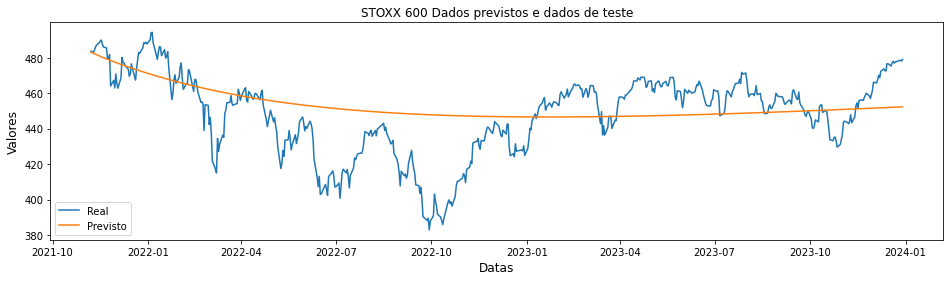

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.plot(arima_test, label="Real")
plt.plot(melhor_predicao, label="Previsto")
plt.title('', fontsize=20)
plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('STOXX 600 Dados previstos e dados de teste')
plt.legend()

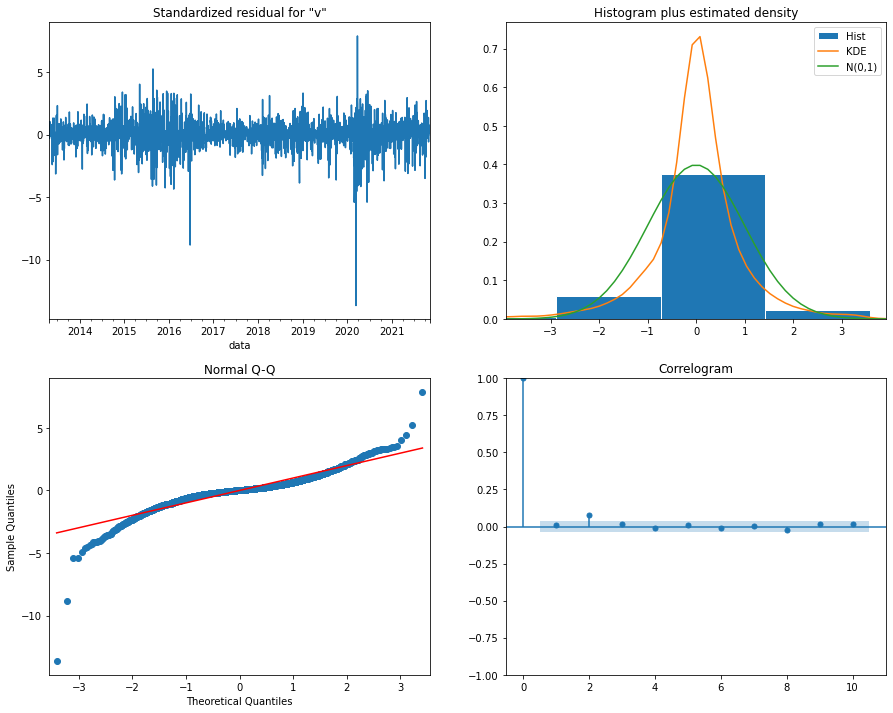

In [15]:
# Suponha que 'modelo_sarima' é o seu modelo SARIMA ajustado
melhor_model.plot_diagnostics(figsize=(15,12))
plt.show()

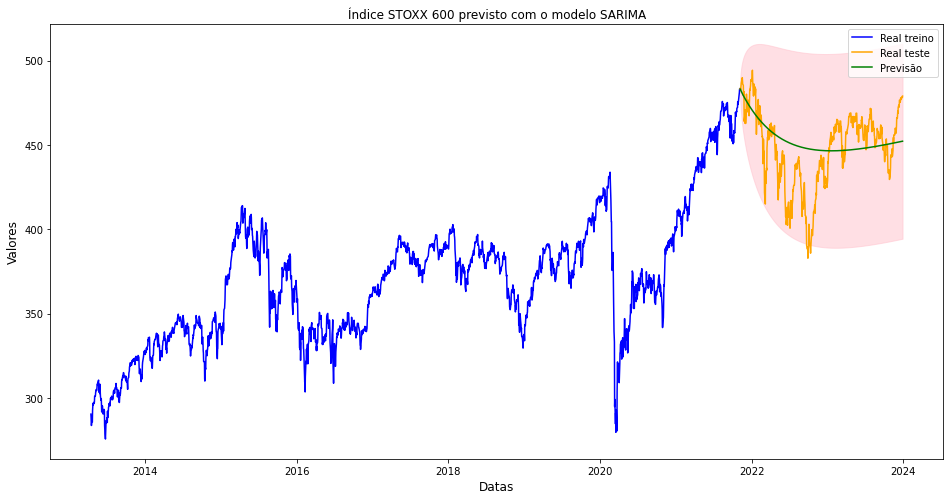

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_predict

# Fazendo previsões
previsoes = melhor_model.get_forecast(steps=len(arima_test))
intervalo_confianca = previsoes.conf_int(alpha=0.05)
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(arima_train.index, arima_train['value'],color='blue', label='Real treino')
plt.plot(arima_test.index, arima_test['value'],color='orange', label='Real teste')

# Linha das previsões
plt.plot(previsoes.predicted_mean.index, previsoes.predicted_mean, color='green', label='Previsão')

# Área do intervalo de confiança
plt.fill_between(intervalo_confianca.index,
                 intervalo_confianca.iloc[:, 0],
                 intervalo_confianca.iloc[:, 1], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice STOXX 600 previsto com o modelo SARIMA')

plt.legend()
plt.show()

# Prophet

## carregando dados

In [39]:
df = ler_csv('dados/STOXX_600.csv')
df_prophet = df_tratamento_dados(df)


In [40]:
len(df_prophet)

3911

## Adequando o df

In [41]:
df_prophet['ds'] = df_prophet.index.copy()
df_prophet.rename(columns={'value': 'y'}, inplace=True)
df_prophet.reset_index(inplace=True, drop=True)
df_prophet.dropna(inplace=True)
df_prophet.tail(9)
len(df_prophet)

3911

## Separando treino e teste

In [42]:
prophet_train, prophet_test = split(df_prophet, 0.8) 

3128
783


In [147]:
def split(df_arima, days):
    train = df_arima[:-days]
    test = df_arima[-days:]
    print(len(train))
    print(len(test))
    return train, test

prophet_train, prophet_test = split(df_prophet, 380)

4727
380


In [190]:
prophet_train

,y,ds
0,290.430000,2013-04-15
1,288.160000,2013-04-16
2,283.730000,2013-04-17
3,283.730000,2013-04-18
4,285.210000,2013-04-19
...,...,...
3123,479.530000,2021-11-02
3124,481.220000,2021-11-03
3125,483.210000,2021-11-04
3126,483.440000,2021-11-05


## Ajustando o modelo

In [43]:
# This function fits the prophet model to the input data and generates a forecast
from prophet import Prophet
def fit_and_forecast(df, periods, interval_width, changepoint_range=1):
    # set the uncertainty interval
    Prophet(interval_width=interval_width)
    # Instantiate the model
    model = Prophet(changepoint_range=changepoint_range)
    # Fit the model
    model.fit(df)
    # Create a dataframe with a given number of dates
    future_df = model.make_future_dataframe(periods=periods,freq='D')
    # Generate a forecast for the given dates
    forecast_df = model.predict(future_df)
    #print(forecast_df.head())
    return forecast_df, model, future_df
# Forecast for 365 days with full data
forecast_df, model, future_df = fit_and_forecast(prophet_train, len(prophet_test), 0.95)
print(forecast_df.columns)
forecast_df[['yhat_lower', 'yhat_upper', 'yhat']].head(5)

07:12:16 - cmdstanpy - INFO - Chain [1] start processing
07:12:17 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,yhat_lower,yhat_upper,yhat
0,273.841705,307.534340,290.430008
1,274.926124,308.881343,290.979167
2,274.315806,307.673632,291.574262
3,274.927431,308.159871,291.655342
4,274.560763,308.586987,291.856423


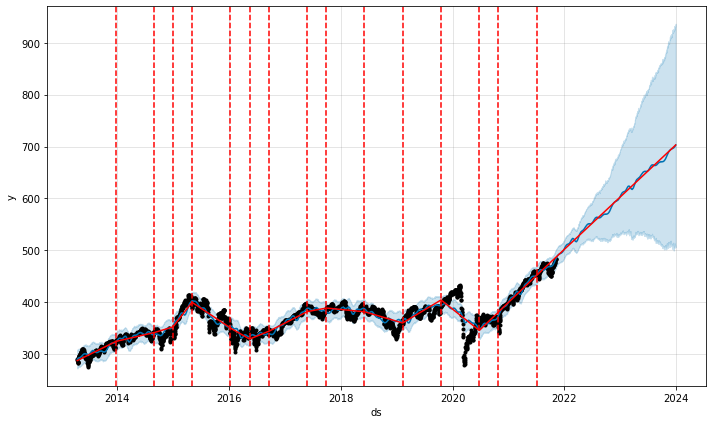

In [24]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, forecast_df)

In [620]:
predicao = forecast_df[['ds','yhat']]
predicao = predicao[len(prophet_train):]

In [621]:
prophet_test

,y,ds
4596,106.472000,2022-08-05
4597,107.115333,2022-08-06
4598,107.758667,2022-08-07
4599,108.402000,2022-08-08
4600,108.651000,2022-08-09
...,...,...
5102,133.143000,2023-12-24
5103,133.338000,2023-12-25
5104,133.533000,2023-12-26
5105,134.194000,2023-12-27


In [623]:
rmse = np.sqrt(mean_squared_error(prophet_test['y'], predicao['yhat']))
rmse

7.821085174542876

## Ajuste de hiperparâmetros

In [91]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_prior_scale':[0.03, 0.05, 0.1],
              'holidays_prior_scale': [5,10,15,20],
               'changepoint_range':[0.8,0.84,0.85,0.9],
              'n_changepoints' : [20,25,50,75,100]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 240


In [212]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_prior_scale':[0.01,0.03],
              'holidays_prior_scale': [20,25],
               'changepoint_range':[0.6,0.7],
              'n_changepoints' : [120,140]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 16


In [44]:
import holidays

# Cria um DataFrame vazio para armazenar os feriados
holiday = pd.DataFrame([])

# Itera sobre os feriados do Brasil entre 2010 e 2023
for date, name in sorted(holidays.Brazil(years=range(2010, 2024)).items()):
    # Adiciona os feriados ao DataFrame
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date, 'holiday': name}, index=[0])], ignore_index=True)

# Converte a coluna 'ds' para o formato datetime
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

# Exibe os primeiros registros do DataFrame
print(holiday.head())

          ds                     holiday
0 2010-01-01  Confraternização Universal
1 2010-04-02           Sexta-feira Santa
2 2010-04-21                  Tiradentes
3 2010-05-01          Dia do Trabalhador
4 2010-09-07     Independência do Brasil


In [45]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':(['additive']),
               'changepoint_prior_scale':[0.03],
              'holidays_prior_scale': [10],
               'changepoint_range':[0.6],
              'n_changepoints' : [120]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 1


In [46]:
import random
import numpy as np
model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
for p in grid:
    
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         changepoint_range=p['changepoint_range'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday, 
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='BR')
    train_model.fit(prophet_train)
    train_forecast = train_model.make_future_dataframe(periods=len(prophet_test), freq='D',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    predicao=train_forecast[['ds','yhat']]
    Actual = prophet_test
    RMSE = np.sqrt(mean_squared_error(Actual['y'], predicao['yhat']))
    MAE = mean_absolute_error(Actual['y'], predicao['yhat'])
    MAPE = mean_absolute_percentage_error(Actual['y'], predicao['yhat'])
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = train_forecast
    print('Root Mean Square Error(RMSE)------------------------------------',RMSE)
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

{'changepoint_prior_scale': 0.03, 'changepoint_range': 0.6, 'holidays_prior_scale': 10, 'n_changepoints': 120, 'seasonality_mode': 'additive'}


07:12:33 - cmdstanpy - INFO - Chain [1] start processing
07:12:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Square Error(RMSE)------------------------------------ 24.792286354518758
total:  100.0


C:\Users\alex\AppData\Local\Temp\ipykernel_13036\2003855335.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [48]:
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,RMSE,Parameters,MAE,MAPE
0,24.792286,"{'changepoint_prior_scale': 0.03, 'changepoint...",18.230119,0.041011


In [47]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

KeyError: 0

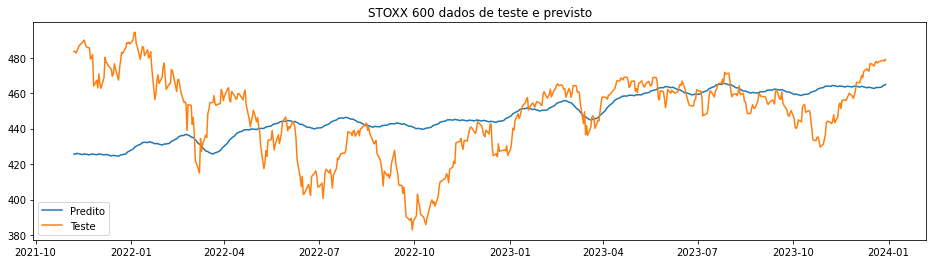

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
# Plotando o primeiro gráfico
plt.plot(predicao['ds'], predicao['yhat'], label='Predito')
# Plotando o segundo gráfico
plt.plot(prophet_test['ds'], prophet_test['y'], label='Teste')
# Adicionando uma legenda
plt.legend()
plt.title('STOXX 600 dados de teste e previsto')
# Exibindo o gráfico
plt.show()

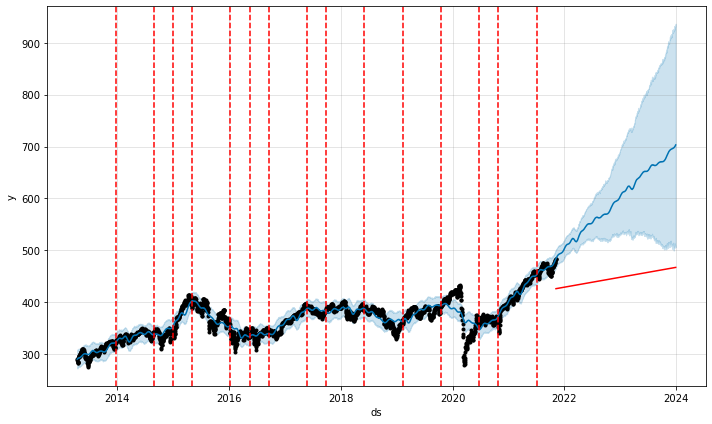

In [33]:
from prophet.plot import add_changepoints_to_plot
axislist = add_changepoints_to_plot(model.plot(forecast_df).gca(), model, train_forecast)

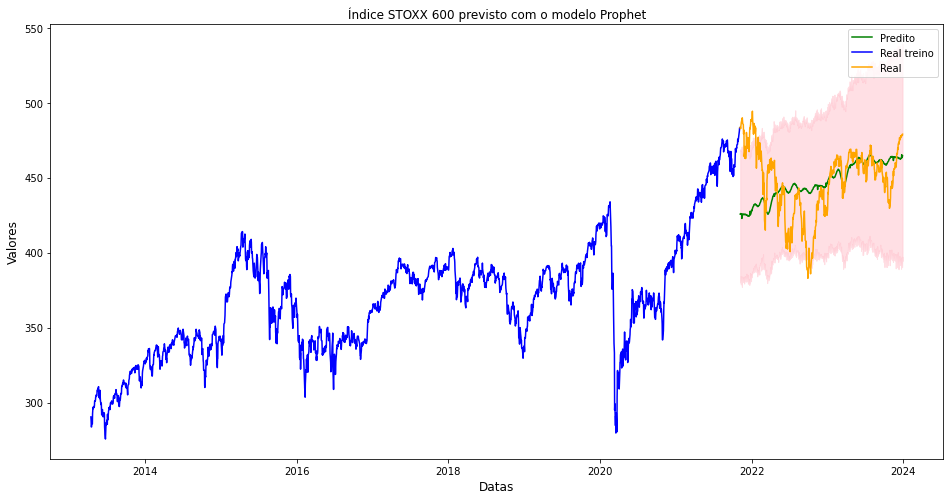

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 8))
# Plotando o primeiro gráfico
plt.plot(best_prediction['ds'], best_prediction['yhat'],color='green', label='Predito')
# Plotando o segundo gráfico
# Linha da série temporal
plt.plot(prophet_train['ds'], prophet_train['y'],color='blue', label='Real treino')
plt.plot(prophet_test['ds'], prophet_test['y'],color='orange', label='Real')

# Área do intervalo de confiança
plt.fill_between(best_prediction['ds'],
                 best_prediction['yhat_upper'],
                 best_prediction['yhat_lower'], color='pink', alpha=0.5)

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice STOXX 600 previsto com o modelo Prophet')
# Adicionando uma legenda
plt.legend()

# Exibindo o gráfico
plt.show()